In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T

sns.set_context('paper', font_scale=1.5)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [2]:
proc_data = pd.read_pickle('data/exp1_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=5, goal_chance=1/3.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 149/149 [02:11<00:00,  1.08it/s]


N clusters = 2, Covarainace = diag
115


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 6

In [4]:
from scipy.stats import ttest_1samp

acc = proc_data[proc_data['In Goal']].groupby(['Training','subj']).mean().loc[True, 'Accuracy']
t, p = ttest_1samp(acc, 1/3.)
print "Mean: {}, t({})={}; p(one-sided)<{}".format(np.mean(acc), len(acc)-1, t, p/2)

Mean: 0.831739130435, t(114)=53.2508964658; p(one-sided)<1.11302686208e-82


In [5]:
acc = proc_data[proc_data['In Goal']].groupby(['Training','subj']).mean().loc[False, 'Accuracy']
t, p = ttest_1samp(acc, 1/3.)
print "Mean: {}, t({})={}; p(one-sided)<{}".format(np.mean(acc), len(acc)-1, t, p/2)

Mean: 0.659710144928, t(114)=20.872267966; p(one-sided)<4.78184593242e-41


Below, we plot the training data as a check that subjects learned the task

/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


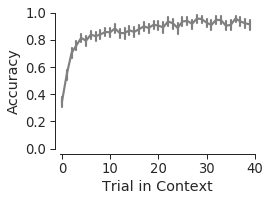

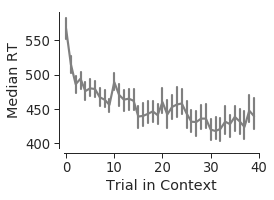

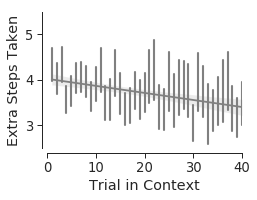

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp_3_goals_training_acc.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    plt.savefig('exp_3_goals_training_rt.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp_3_goals_training_steps.png', dpi=300, bbox_inches='tight')

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.108645,0.005117,0.000153,0.098568,0.118894,924.611095,1.000705
beta_reps,1.106030,0.058041,0.001713,0.995778,1.218345,1051.350293,0.999455


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.007636,0.000680,0.000025,0.006331,0.008916,834.855430,0.999672
beta_reps,0.053963,0.017969,0.000510,0.016300,0.085862,1136.417938,0.999934


In [7]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=1.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=1.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=1.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=1.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub, mu_subj, beta_reps, beta_times]
The acceptance probability does not match the target. It is 0.941401221236804, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.003517,0.000374,0.000016,-0.004268,-0.002825,349.571333,1.023369
beta_reps,-0.406424,0.009851,0.000303,-0.425015,-0.387082,1094.659540,1.002165


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

/anaconda3/envs/compgen/lib/python2.7/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


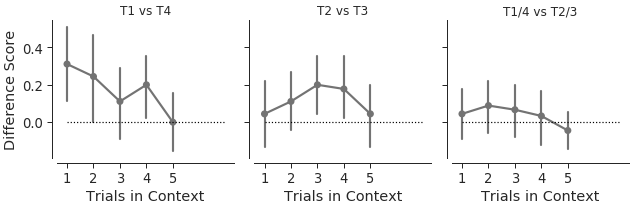

In [8]:
# plot the difference scores across time
df0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[6, 'Accuracy'] - grouped.loc[9, 'Accuracy']
        diff_2 = grouped.loc[7, 'Accuracy'] - grouped.loc[8, 'Accuracy']
        diff_3 = (grouped.loc[6, 'Accuracy'] + grouped.loc[9, 'Accuracy']) * 0.5 \
                - (grouped.loc[7, 'Accuracy'] + grouped.loc[8, 'Accuracy']) * 0.5

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T4'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T2 vs T3'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1/4 vs T2/3'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))


score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T4'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T2 vs T3'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1/4 vs T2/3'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T4', fontdict={'size': 12})
    axes[1].set_title('T2 vs T3', fontdict={'size': 12})
    axes[2].set_title('T1/4 vs T2/3', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=False)
    plt.tight_layout()
    plt.savefig('fig_exp1_supp_diff_new.pdf', dpi=300, bbox_inches='tight')

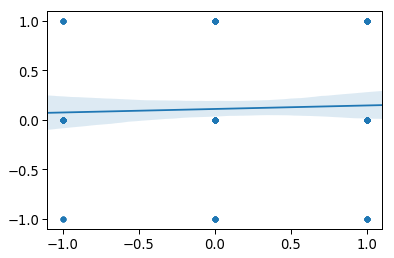

In [9]:
sns.regplot(score.loc[score.Comparison=='T1 vs T4', 'Difference Score'].values,
            score.loc[score.Comparison=='T2 vs T3', 'Difference Score'].values)

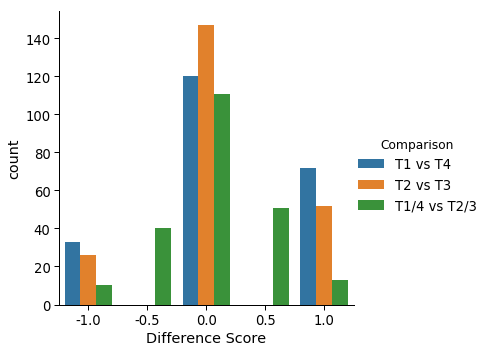

In [10]:
sns.catplot(data=score, kind='count', x='Difference Score', hue='Comparison')

[[1.         0.04019679]
 [0.04019679 1.        ]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Accuracy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7698
Date:                Thu, 31 Jan 2019   Prob (F-statistic):              0.382
Time:                        13:42:32   Log-Likelihood:                -37.970
No. Observations:                 115   AIC:                             77.94
Df Residuals:                     114   BIC:                             80.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Accuracy       0.0667      0.076      0.877      0.382      -0.084       0.217
==============================================================================
Omnibus:                        0.007   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.099
Skew:                           0.015   Prob(JB):                        0.952
Kurtosis:                       2.860   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

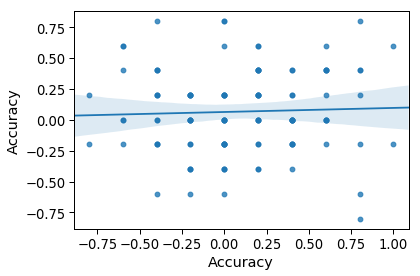

In [11]:
df0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

grouped = df0.groupby(['Context', 'subj', ]).mean() 
indep = grouped.loc[6, :].Accuracy - grouped.loc[9, :].Accuracy
joint = grouped.loc[7, :].Accuracy - grouped.loc[8, :].Accuracy
print np.corrcoef([indep, joint])
sns.regplot(indep, joint)

import statsmodels.api as sm
sm.OLS(joint, indep).fit().summary()

In [4]:
# run the bayesian GLM on the raw data

# create meaningful regressors
# really on only want to look at training
X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
               (proc_data['Times Seen Context'] <= 5)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype='int') - \
     (X0.Context.values == 9)
    
x_2 = np.array(X0.Context.values == 7, dtype='int') - \
     (X0.Context.values == 8) 
    
x_3 = np.array((X0.Context.values == 6) | (X0.Context.values == 9), dtype='int') - \
     ((X0.Context.values == 7) | (X0.Context.values == 8))
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs4', mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT2vs3', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT1/4vs2/3',  mu=0., sd=100)
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_ctxT1/4vs2/3, beta_ctxT2vs3, beta_ctxT1vs4]


In [5]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


In [6]:
df_comp_LOO = pm.compare({glm:trace, glm_reduced:trace_reduced}, ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full',  'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

/Users/nicholasfranklin/anaconda3/envs/compgen/lib/python2.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
Full,2907.97,93.78,0,0.81,42.33,0,0
Reduced,2922.74,88.7,14.77,0.19,40.68,9.81,0


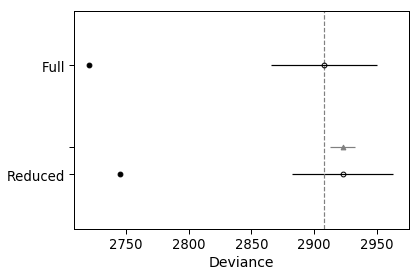

In [7]:
pm.compareplot(df_comp_LOO)

In [8]:
summary = pm.summary(trace, varnames=[
    'beta_ctxT1vs4', 'beta_ctxT2vs3', 'beta_ctxT1/4vs2/3',
    'beta_times', 'beta_reps', 'mu_subj'])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs4,0.230256,0.069032,0.000791,0.098339,0.369806,6211.068450,0.999752
beta_ctxT2vs3,0.123216,0.064041,0.000785,0.002623,0.252980,6453.987694,0.999840
beta_ctxT1/4vs2/3,0.101155,0.046141,0.000629,0.014268,0.193869,5754.234759,0.999783
beta_times,0.431610,0.038371,0.000971,0.352104,0.501865,1657.623417,1.000054
beta_reps,0.752852,0.137491,0.001753,0.485700,1.018559,5777.536001,0.999859
mu_subj,-0.984340,0.134896,0.003033,-1.249486,-0.727097,1853.689822,1.000689


In [9]:
#these are p-values
print "mimum p-value ", 1/2000.
print np.mean(trace['beta_ctxT1vs4'] > 0)
print np.mean(trace['beta_ctxT2vs3'] > 0)
print np.mean(trace['beta_ctxT1/4vs2/3'] > 0)
print np.mean(trace['beta_times'] < 0)
print np.mean(trace['beta_reps'] < 0)

mimum p-value  0.0005
0.99925
0.97275
0.98625
0.0
0.0


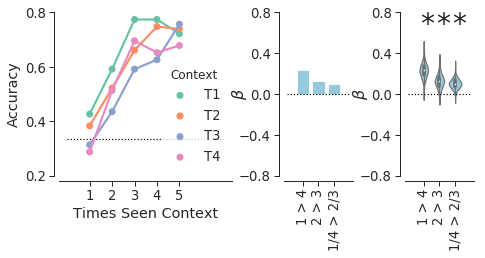

In [10]:
betas = pd.DataFrame({
        'T1vsT4': trace['beta_ctxT1vs4'],
        'T2vsT3': trace['beta_ctxT2vs3'],
        'T1/4vsT2/3':   trace['beta_ctxT1/4vs2/3']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                  data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT4', 'T2vsT3', 'T1/4vsT2/3'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT4', 'T2vsT3', 'T1/4vsT2/3'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 4', u'2 > 3', r'1/4 > 2/3' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs4', 'beta_ctxT2vs3','beta_ctxT1/4vs2/3']):
        if np.mean(trace[label] > 0) > 0.95:
#         if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.6), size=28)


In [11]:
# run the bayesian GLM on the raw data

# create meaningful regressors
# really on only want to look at training
X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
               (proc_data['Times Seen Context'] <= 5)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype='int') - \
     (X0.Context.values == 9)
    
x_2 = np.array(X0.Context.values == 7, dtype='int') - \
     (X0.Context.values == 8) 
    
x_3 = np.array((X0.Context.values == 6) | (X0.Context.values == 9), dtype='int') - \
     ((X0.Context.values == 7) | (X0.Context.values == 8))
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as heir_glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    mu_b1 = pm.Normal('mu_beta_ctxT1vs4', mu=0., sd=100)
    mu_b2 = pm.Normal('mu_beta_ctxT2vs3', mu=0., sd=100)
    mu_b3 = pm.Normal('mu_beta_ctxT14vs23', mu=0., sd=100)
    mu_bt = pm.Normal('mu_beta_times', mu=0., sd=100)
    mu_bc = pm.Normal('mu_beta_beta_reps', mu=0., sd=100)

    sigma_b1 = pm.HalfCauchy('sigma_beta_ctxT1vs4', beta=100)
    sigma_b2 = pm.HalfCauchy('sigma_beta_ctxT2vs3', beta=100)
    sigma_b3 = pm.HalfCauchy('sigma_beta_ctxT14vs23', beta=100)
    sigma_bt = pm.HalfCauchy('sigma_beta_times', beta=100)
    sigma_bc = pm.HalfCauchy('sigma_beta_beta_reps', beta=100)
    
    b_1 = pm.Normal('beta_ctxT1vs4', mu=mu_b1, sd=sigma_b1, shape=n_subj)
    b_2 = pm.Normal('beta_ctxT2vs3', mu=mu_b2, sd=sigma_b2, shape=n_subj)
    b_3 = pm.Normal('beta_ctxT14vs23',  mu=mu_b3, sd=sigma_b3, shape=n_subj)
    b_ti = pm.Normal('beta_times',    mu=mu_bt, sd=sigma_bt, shape=n_subj)
    b_cr = pm.Normal('beta_reps',     mu=mu_bc, sd=sigma_bc, shape=n_subj)
    
    # random effects modeled as constant addded/subtracted per subject

    a = pm.Normal('a_subj', mu=0., sd=100.)
    
    # Regression model
    y_hat = tinvlogit(b_1[subj_idx] * x_1 + b_2[subj_idx] * x_2 + b_3[subj_idx] * x_3 + \
                      b_ti[subj_idx] * x_ti + b_cr[subj_idx] * x_cr + a)
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    hier_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, beta_reps, beta_times, beta_ctxT14vs23, beta_ctxT2vs3, beta_ctxT1vs4, sigma_beta_beta_reps, sigma_beta_times, sigma_beta_ctxT14vs23, sigma_beta_ctxT2vs3, sigma_beta_ctxT1vs4, mu_beta_beta_reps, mu_beta_times, mu_beta_ctxT14vs23, mu_beta_ctxT2vs3, mu_beta_ctxT1vs4]


KeyboardInterrupt: 

In [ ]:
sns.regplot(np.mean(hier_trace['beta_ctxT1vs4'], axis=0), np.mean(hier_trace['beta_ctxT2vs3'], axis=0),)

In [ ]:
rs = [np.corrcoef(hier_trace['beta_ctxT1vs4'][ii, :], hier_trace['beta_ctxT2vs3'][ii, :])[0][1] for ii in range(4000)]
sns.distplot(rs)

In [ ]:
np.mean(np.array(rs) > 0)

# Paper Figures

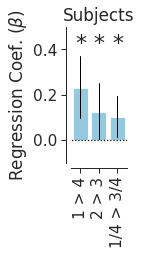

In [12]:

sns.set_context('paper', font_scale=1.75)


betas = pd.DataFrame({
        'T1vsT4': trace['beta_ctxT1vs4'],
        'T2vsT3': trace['beta_ctxT2vs3'],
        'T1/4vsT2/3':   trace['beta_ctxT1/4vs2/3']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

    sns.barplot(data=pd.melt(betas), x='variable', y='value',
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT4', 'T2vsT3', 'T1/4vsT2/3'])
    for ii, b in enumerate(['beta_ctxT1vs4', 'beta_ctxT2vs3','beta_ctxT1/4vs2/3']):
        ylb = summary.loc[b, 'hpd_2.5']
        yub = summary.loc[b, 'hpd_97.5']
        ax.plot([ii,ii], [ylb, yub], 'k', linewidth=1)
    
    ax.set_ylabel(r'Regression Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})

    
    sns.despine(offset=5)

    plt.xticks([0, 1, 2], [r'1 > 4', u'2 > 3', r'1/4 > 3/4' ], rotation='vertical')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_xlabel('')
    ax.set_ylim([-0.1, 0.5])
    ax.set_xlim([-0.5, 2.5])

    for ii, label in enumerate(['beta_ctxT1vs4', 'beta_ctxT2vs3','beta_ctxT1/4vs2/3']):
        if np.mean(trace[label] > 0) > 0.95:
            ax.annotate("*", xy=(ii-0.27, 0.40), size=22)
            
    plt.title('Subjects',)
#     plt.savefig('exp_3goals_behav_new.png', dpi=300, bbox_inches='tight')
    

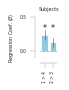

In [26]:
height=0.75
hdi=0.95
from matplotlib import gridspec


with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(height/2.5, height))


        betas = pd.DataFrame({
                'T1vsT4': trace['beta_ctxT1vs4'],
                'T2vsT3': trace['beta_ctxT2vs3'],
    #             'T1/4vsT2/3':   trace['beta_ctxT1/4vs2/3']
            })

#         fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

        sns.barplot(data=pd.melt(betas), x='variable', y='value',
                     estimator=np.median, color='skyblue', ci='sd',
                       order=['T1vsT4', 'T2vsT3'], errwidth=0.5)
#         for ii, b in enumerate(['beta_ctxT1vs4', 'beta_ctxT2vs3']):
#             ylb = summary.loc[b, 'hpd_2.5']
#             yub = summary.loc[b, 'hpd_97.5']
#             ax.plot([ii,ii], [ylb, yub], 'k', linewidth=1)

        ax.set_ylabel(r'Regression Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})


        sns.despine(offset=5)

        plt.xticks([0, 1 ], [r'1 > 4', u'2 > 3' ], rotation='vertical')
        ax.plot([-1, 2], [0, 0], 'k:', lw=0.5)
        ax.set_xlabel('')
        ax.set_ylim([-0.1, 0.5])
        ax.set_xlim([-0.5, 1.5])

        for ii, label in enumerate(['beta_ctxT1vs4', 'beta_ctxT2vs3','beta_ctxT1/4vs2/3']):
            if np.mean(trace[label] > 0) > 0.95:
                ax.annotate("*",  xy=(ii-0.2, 0.3), size=8)
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

        plt.title('Subjects',)
    plt.savefig('exp_3goals_behav.png', dpi=300, bbox_inches='tight')
    

In [24]:
# # run the bayesian GLM on the raw data

# # create meaningful regressors
# # really on only want to look at training
# X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
#                (proc_data['Times Seen Context'] <= 5)].copy()

# X0['subj_id'] = [None] * len(X0)
# for ii, uid in enumerate(uids):
#     X0.loc[X0.subj == uid, 'sub_id'] = ii

# n_subj = int(max(X0.sub_id) + 1)


# y = np.array(X0['Accuracy'].values)
# subj_idx = np.array(X0['sub_id'].values, dtype='int')
# x_1 = np.array(X0.Context.values == 6, dtype='int') - \
#      (X0.Context.values == 9)
    
# x_2 = np.array(X0.Context.values == 7, dtype='int') - \
#      (X0.Context.values == 8) 
    
# x_3 = np.array((X0.Context.values == 6) | (X0.Context.values == 9), dtype='int') - \
#      ((X0.Context.values == 7) | (X0.Context.values == 8))
    
# x_ti = X0['Times Seen Context'].values
# x_cr = X0['Context Repeated'].values

# def tinvlogit(x):
#     return T.exp(x) / (1 + T.exp(x))

# with pm.Model() as glm2:
        
#     # Intercept for each subjects, distributed around group mean mu_a
#     a_sub = pm.Normal('a_subj', mu=0, sd=100, )

    
#     # random effects modeled as constant addded/subtracted per subject
#     mu_b1 = pm.Normal('mu_b1', mu=0., sd=100)
#     mu_b2 = pm.Normal('mu_b2', mu=0., sd=100)
#     mu_b3 = pm.Normal('mu_b3', mu=0., sd=100)
#     mu_bt = pm.Normal('mu_bt', mu=0., sd=100)
#     mu_bc = pm.Normal('mu_bc', mu=0., sd=100)
#     sigma_b1 = pm.HalfCauchy('sigma_b1', beta=100)
#     sigma_b2 = pm.HalfCauchy('sigma_b2', beta=100)
#     sigma_b3 = pm.HalfCauchy('sigma_b3', beta=100)
#     sigma_bt = pm.HalfCauchy('sigma_bt', beta=100)
#     sigma_bc = pm.HalfCauchy('sigma_bc', beta=100)

#     b_1 = pm.Normal('beta_ctxT1vs4', mu=mu_b1, sd=sigma_b1, shape=n_subj)
#     b_2 = pm.Normal('beta_ctxT2vs3', mu=mu_b2, sd=sigma_b2, shape=n_subj)
#     b_3 = pm.Normal('beta_ctxT1/4vs2/3',  mu=mu_b3, sd=sigma_b3, shape=n_subj)
#     b_ti = pm.Normal('beta_times',    mu=mu_bt, sd=sigma_bt, shape=n_subj)
#     b_cr = pm.Normal('beta_reps',     mu=mu_bc, sd=sigma_bc, shape=n_subj)
    
#     # Regression model
#     y_hat = tinvlogit(b_1[subj_idx] * x_1 + b_2[subj_idx] * x_2 + b_3[subj_idx] * x_3 + \
#                       b_ti[subj_idx] * x_ti + b_cr[subj_idx] * x_cr + a_sub)
        
#     #error term
#     stdev = pm.HalfCauchy('eps', beta=100)
    
#     # Data likelihood
#     y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
#     trace2 = pm.sample(2000)

In [25]:
# trace2

/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning

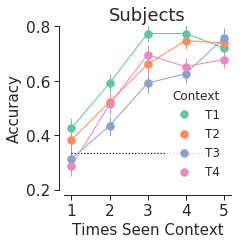

In [26]:
#within subject errorbars (standard error)
from matplotlib.ticker import NullFormatter  # useful for `logit` scale


cc = sns.color_palette('Set2')
def plot_test_context(ctx, ax, color, label):
    ctx = df.loc[(df['Times Seen Context'] < 6) & (df['Context'] == ctx), 'Accuracy'
                ].values.reshape(len(uids), -1)
    
    ctx_std_err = np.std(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T - 
                         ctx.mean(), axis=0) / np.sqrt(len(uids))

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=1)
    
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(3,3))
    plot_test_context(6, ax, cc[0], 'T1')
    plot_test_context(7, ax, cc[1], 'T2')
    plot_test_context(8, ax, cc[2], 'T3')
    plot_test_context(9, ax, cc[3], 'T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticks(range(1, 6))
    ax.set_xlabel('Times Seen Context', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.plot([1, 5], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    plt.gca().yaxis.set_minor_formatter(NullFormatter())

    plt.title('Subjects', fontsize=18, fontname='Helvetica')
    sns.despine(offset=5)
    
    
# plt.savefig('exp1_fig1a_data.png', dpi=300, bbox_inches='tight')

In [27]:
# asses accuracy on first trial in test contexts
# Do a "Bayesian Analysis" to follow up
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)  & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 6, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 7, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 9, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling
    
print np.mean(trace_bin['theta1'] > 1/3.)
print np.mean(trace_bin['theta2'] > 1/3.)
print np.mean(trace_bin['theta3'] > 1/3.)
print np.mean(trace_bin['theta4'] > 1/3.)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta4]
>Metropolis: [theta3]
>Metropolis: [theta2]
>Metropolis: [theta1]
The number of effective samples is smaller than 25% for some parameters.


0.9791
0.873
0.31255
0.1375


In [28]:
pm.summary(trace_bin)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.424369,0.045550,0.000777,0.335449,0.510406,3541.575848,1.000108
theta2,0.382919,0.044838,0.000791,0.297469,0.472716,3518.617752,1.000102
theta3,0.313253,0.042587,0.000783,0.232695,0.399196,3186.530822,1.000093
theta4,0.287313,0.041971,0.000782,0.204414,0.365940,2948.695966,1.000237


In [29]:
trace.varnames

['beta_ctxT1vs4',
 'beta_ctxT2vs3',
 'beta_ctxT1/4vs2/3',
 'beta_times',
 'beta_reps',
 'mu_subj',
 'sigma_sub_log__',
 'a_subj',
 'eps_log__',
 'sigma_sub',
 'eps']

In [30]:
# pm.plot_posterior(trace['beta_ctxT1vs4'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4'])

In [31]:
# np.mean((trace['beta_ctxT1vs24'] - trace['beta_ctxT3vs24'] + trace['beta_ctxT2vs4']) > 0)

In [32]:
# rs = [np.corrcoef(trace_hier.beta_ctxT1vs24[ii, :], trace_hier.beta_ctxT3vs24[ii, :])[0][1] for ii in range(1000)]

In [33]:
# print np.mean(rs)
# print np.mean(np.array(rs) < 0)
# sns.distplot(rs)

In [34]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)
               & ~proc_data['Training'] ]
print set(d0.Context)

set([8.0, 9.0, 6.0, 7.0])


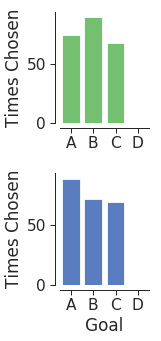

In [35]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(2.5, 5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==6) | (proc_data['Context']==9))]

    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==7) | (proc_data['Context']==8)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=axes[1], order='A B C D'.split(), color=cc[0])
    sns.countplot(d1['Chosen Goal'], ax=axes[0], order='A B C D'.split(), color=cc[2])
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')
    
    ax = axes[1]
    ax.set_xlabel('Goal')

    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()

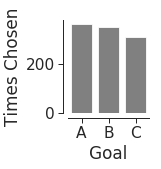

In [36]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.5, 2.5))

    d01 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)]


    cc = sns.color_palette('muted')
    sns.countplot(d01['Chosen Goal'], ax=ax, order='A B C'.split(), color='grey')
    
    ax.set_ylabel('Times Chosen')
    
    ax.set_xlabel('Goal')
    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()

In [37]:
y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta2, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta3, observed=y_C_m1)
    
    # Generate a MCMC chain
    trace = pm.sample(2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta3, theta2, theta1]


In [38]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.354134,0.022103,0.000260,0.308878,0.395205,6190.355483,0.999801
theta2,0.350246,0.022029,0.000258,0.308831,0.395256,5831.133980,0.999773
theta3,0.295117,0.020805,0.000297,0.256459,0.338433,5584.269591,0.999846


In [40]:
pm.stats.hpd(trace['theta1'] - trace['theta2'])

array([-0.05626658,  0.0635434 ])

In [41]:
pm.stats.hpd(trace['theta1'] - trace['theta3'])

array([0.00055329, 0.11892834])

In [42]:
pm.stats.hpd(trace['theta2'] - trace['theta3'])

array([-0.00446641,  0.11244027])

In [43]:
np.mean(trace['theta2'] - trace['theta3'] > 0)

0.964

In [45]:
y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 


with pm.Model() as model_full:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    
    # define the prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    theta5 = pm.Beta('theta5', 10e-5, 10e-5)  # prior
    theta6 = pm.Beta('theta6', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta4, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta5, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta6, observed=y_C_m1)
    
    # Generate a MCMC chain
    trace_full = pm.sample(2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta6, theta5, theta4, theta3, theta2, theta1]


In [47]:
pm.summary(trace_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.386912,0.031729,0.000418,0.327926,0.451254,5607.695068,0.999999
theta2,0.313285,0.030930,0.000373,0.254533,0.374687,7484.984031,0.999874
theta3,0.300202,0.029002,0.000366,0.246203,0.358496,6786.776554,0.999979
theta4,0.321355,0.030467,0.000376,0.260064,0.378016,6050.724101,0.999851
theta5,0.386422,0.031874,0.000446,0.323732,0.448385,4959.170212,0.999805
theta6,0.291425,0.029444,0.000390,0.233412,0.348097,5043.565472,0.999765
